## Patient SEEG avalanche analysis
1. <ins>Always run</ins>:
    1. Housekeeping - define and load relevant files
1. <ins>Starting point 1</ins>:
    1. Define parameters of parameter sweep and avalanche estimation
    1. Perform actual [parameter sweep](#Parameter-Sweep)
1. <ins>Starting point 2</ins>: 
    1. [Plot parameter sweep results](#Plot-parameter-sweep-results)
    1. [Recalculate avalanches with specific parameter set](#Calculate-avalanches-with-parameter-values-identified-from-sweep) identified from parameter sweep
    1. [Plot parameters (i.e. alpha) of the powerlaw fit](#Plot-parameters-of-power-law-fit) for seizures and baseline
1. <ins>Starting point 3</ins>:
    1. [Plot dimensionality analysis](#Dimensionality-evaluation)

In [2]:
# Housekeeping
#===============================================================================
import mne
import numpy as np
import os, re, sys, copy
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
from importlib import reload
from sklearn import decomposition
import powerlaw as pl
import pickle
import cde_seeg_functions as cs
import cde_seeg_importancesampling as ci
reload(cs)
reload(ci)

# Define folder locations
#-------------------------------------------------------------------------------
F = {}
F['base']    = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy'
F['save']    = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy Data'
F['scripts'] = F['base'] +os.sep+ '07 - SEEG'
F['seeg']    = '/Volumes/GoogleDrive/My Drive/Research/1808 Intracranial Seizure Data'
Sublist      = cs.subject_specify(F)

# Manual definitions of various parameters
#===============================================================================
# Preprocessing
#-------------------------------------------------------------------------------
PP = {}
PP['Bands']          = [('broad', 1, 250),        # Frequency bands to be included in parameter sweep
                        ('delta', 1, 4), 
                        ('theta', 4, 8),
                        ('alpha', 8, 15),
                        ('beta', 15, 30), 
                        ('gamma', 30, 80), 
                        ('highg', 80,250)]

band                 = 'highg'                   # Specify if only a single band is to be used
thisb                = [item for item in PP['Bands'] if band in item]
PP['Fbp']            = (thisb[0][1],thisb[0][2])      # Bandpass filter frequency band

# Binarisation
#-------------------------------------------------------------------------------
BN = {}
BN['separation_win'] = 0                         # Minimum enforced separation between peaks
BN['peak_height']    = 3                         # Minimum peak height (in z-score)
BN['edgewin']        = 1000                      # Section at the edge being ignored (to avoid filter artefact)

# Avalanche size estimation
#-------------------------------------------------------------------------------
AS = {} 
AS['dt']             = 3                         # delta t for detection of concurrent events (in samples)

# Parameter range used for parameter sweep
#-------------------------------------------------------------------------------
prange = np.linspace(2, 6, 12)                   # parameter ranges for sweep
trange = np.linspace(2, 21, 20).astype('int')    # parameter ranges for sweep 

# Parameter values idenitified from sweep and used for subsequent analysis
#-------------------------------------------------------------------------------
Parset                   = {}
Parset['band']           = PP['Bands'][0]
Parset['Fbp']            = (Parset['band'][1], Parset['band'][2])
Parset['dt']             = 5
Parset['peak_height']    = 4

## Parameter Sweep

#### Load EEG and identify avalanches

In [43]:
reload(cs)

# Load and preprocess EEG segments
#===============================================================================
# Subs = cs.avcalc(Sublist, PP['Bands'], BN, AS, prange, trange)
Subs = cs.avcalc(Sublist, [('broad', 1, 250)], BN, AS, [4], [5])

Frequency band 1 to 250Hz (broadband)
Working on subject 1 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 2 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 3 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 4 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 5 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 6 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 7 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 8 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 9 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 10 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 11 of 30
Processing: > Done
Frequency band 1 to 250Hz (broadband)
Working on subject 12 of 30
Processi

#### Save sweep results if desired (edit if needed, will not save by default)

In [45]:
# Save sweep results
#===============================================================================
if False:                  # <- change this if you actually to save the results
    Sweeps = []
    for s in Subs: Sweeps.append(s['Sweep'])
    with open(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+band[0]+'.pkl', 'wb') as handle:
        pickle.dump(Sweeps, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load saved parameter sweep data

In [51]:
# Load individual patient data
#-------------------------------------------------------------------------------
subs = []
for s in range(len(Sublist)):
    subs.append(cs.subject_load(Sublist[s], PP))

In [11]:
cond        = 'bl'
PP['Alpha'] = []
PP['Var']   = []
PP['BF']    = []

for band in range(len(PP['Bands'])):
    print('Working on ' + PP['Bands'][band][0] + ' frequency band')
    # Load picked file for the specific frequency band
    #--------------------------------------------------------------------------------------------
    Sweep = pickle.load(open(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+PP['Bands'][band][0]+'.pkl', 'rb'))
    
    # fit power laws to each parameter value
    #--------------------------------------------------------------------------------------------
    print('Fitting individual power laws for ' + PP['Bands'][band][0] + ' band')
    DM = []
    for s in range(len(Sweep)):
        dm = cs.plot_sweep(Sweep[s], doplot = False, cond=cond)
        DM = dm if DM == [] else np.dstack((DM, dm))
        
    # Estimate marginal likelihoods 
    #--------------------------------------------------------------------------------------------
    print('Estimating marginal likelihoods for ' + PP['Bands'][band][0] + ' band')
    BF = []
    for s in range(len(Sweep)):
        bf = cs.plot_sweep(Sweep[s], doplot = False, cond=cond, param = 'likelihood')
        BF = bf if BF == [] else np.dstack((BF, bf))
    
    # Pack up
    #--------------------------------------------------------------------------------------------
    PP['Alpha'].append(DM)
    PP['Var'].append(np.nanvar(DM,axis=2))
    PP['BF'].append(BF)


#### Plot results from parameter sweep

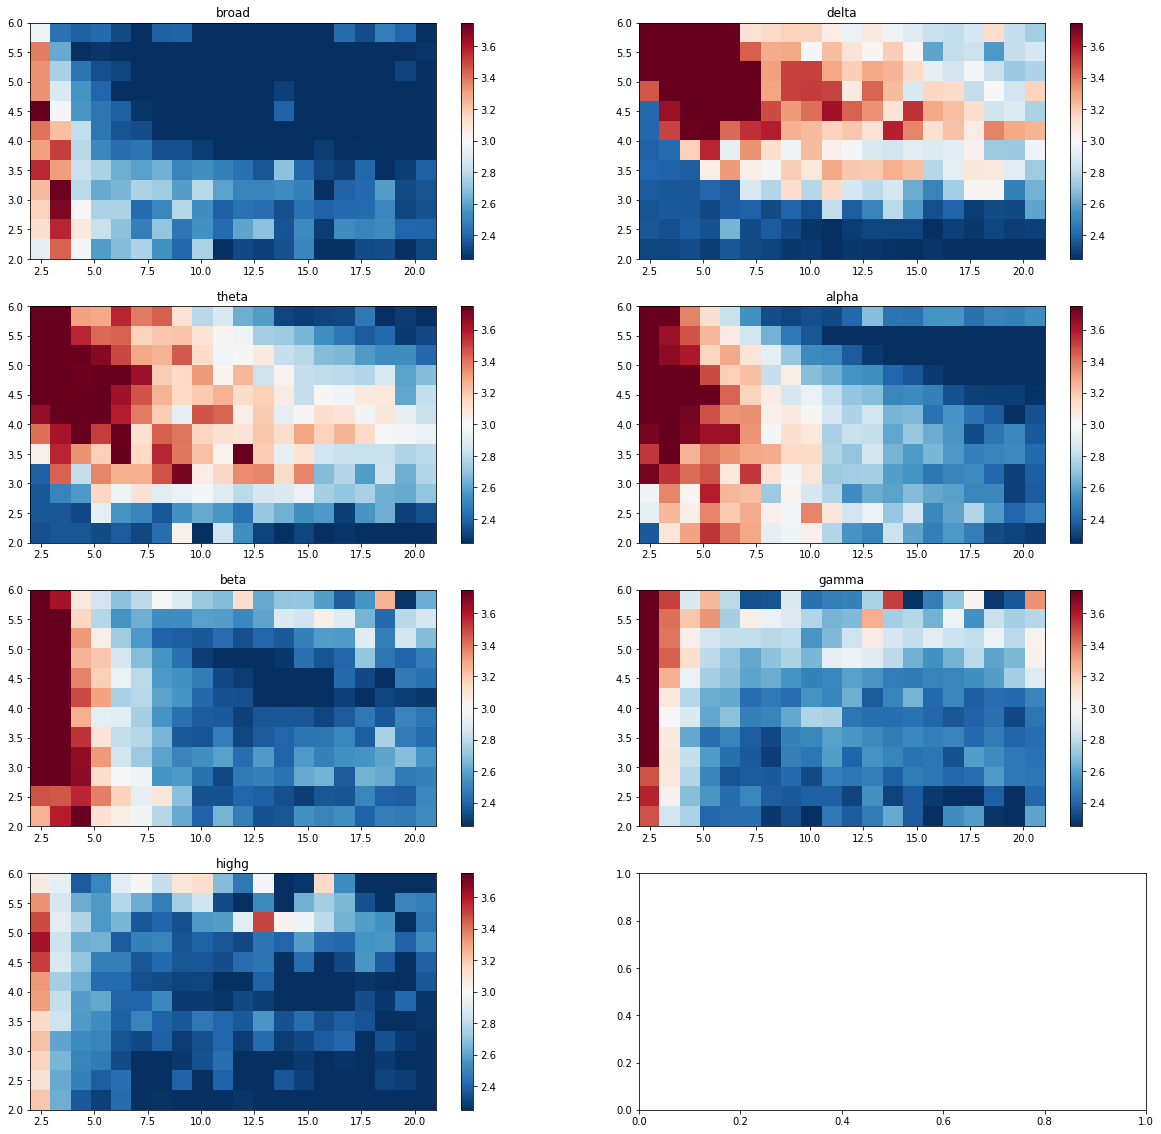

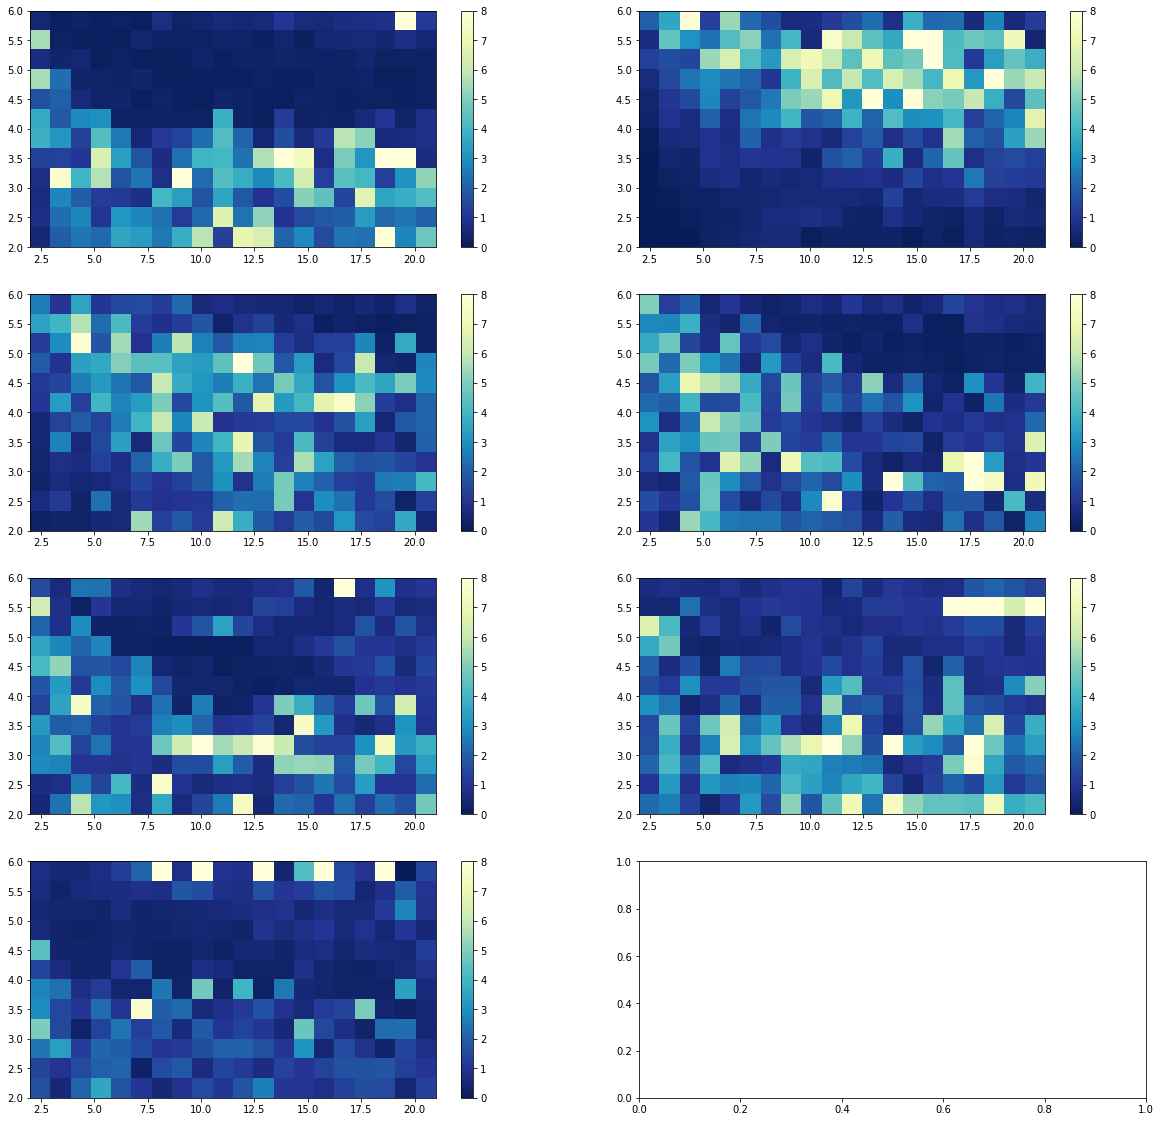

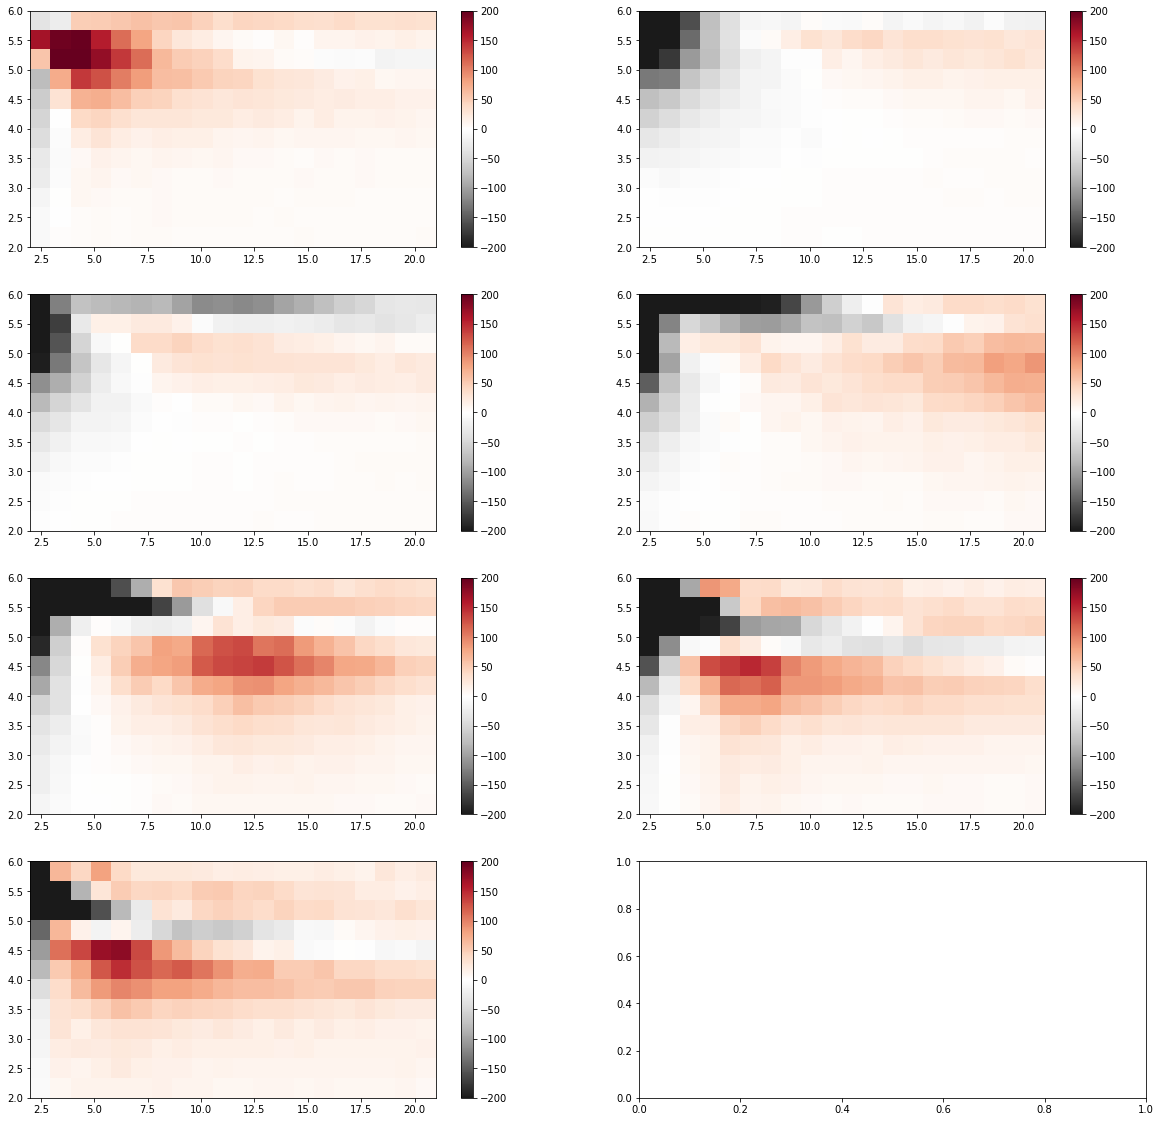

In [12]:
fig1, ax1   = plt.subplots(4,2,figsize = (20,20))  # alpha
fig2, ax2   = plt.subplots(4,2,figsize = (20,20))  # variance 
fig3, ax3   = plt.subplots(4,2,figsize = (20,20))  # Log likelihood ratio
    
extentxy = (Sweep[s]['Time windows'][0], Sweep[s]['Time windows'][-1], 
            Sweep[s]['Peak thresholds'][0], Sweep[s]['Peak thresholds'][-1])   

for band in range(len(PP['Bands'])):
    # Plot mean map of the extracted values 
    #--------------------------------------------------------------------------------------------
    img = ax1.flatten()[band].imshow(np.nanmedian(PP['Alpha'][band], axis=2),extent=extentxy,cmap='RdBu_r', 
                                     aspect='auto', vmin=2.25, vmax=3.75)
    fig1.colorbar(img, ax=ax1.flatten()[band])
    ax1.flatten()[band].set_title(PP['Bands'][band][0])
    
    # Plot variance across map
    #--------------------------------------------------------------------------------------------
    img = ax2.flatten()[band].imshow(PP['Var'][band],extent=extentxy,cmap='YlGnBu_r', aspect='auto', 
                                     vmin=0, vmax=8)
    fig2.colorbar(img, ax=ax2.flatten()[band])
    
    # Plot bayes factor across map
    #--------------------------------------------------------------------------------------------
    
    bf  = np.nanmedian(PP['BF'][band],axis=2)
    img = ax3.flatten()[band].imshow(bf,extent=extentxy,cmap='RdGy_r', aspect='auto',
                                     vmin=-200, vmax=200)
    fig3.colorbar(img, ax=ax3.flatten()[band])

## Plot individual examples
From the plot above, we can select values for the avalanche evaluation that produce a near critical distribution - e.g. `dt = 5` and `p = 4` (defined up top)

In [52]:
Sweep = pickle.load(open(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+
                         os.sep+Parset['band'][0]+'.pkl', 'rb'))
AS['dt']             = Parset['dt']
BN['peak_height']    = Parset['peak_height']

/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:308: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(avc_binned[1][1:]), np.log(avc_cdf), color=tc)
/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:308: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(avc_binned[1][1:]), np.log(avc_cdf), color=tc)
/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:308: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(avc_binned[1][1:]), np.log(avc_cdf), color=tc)
/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:308: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(avc_binned[1][1:]), np.log(avc_cdf), color=tc)
/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:308: RuntimeWarning: div

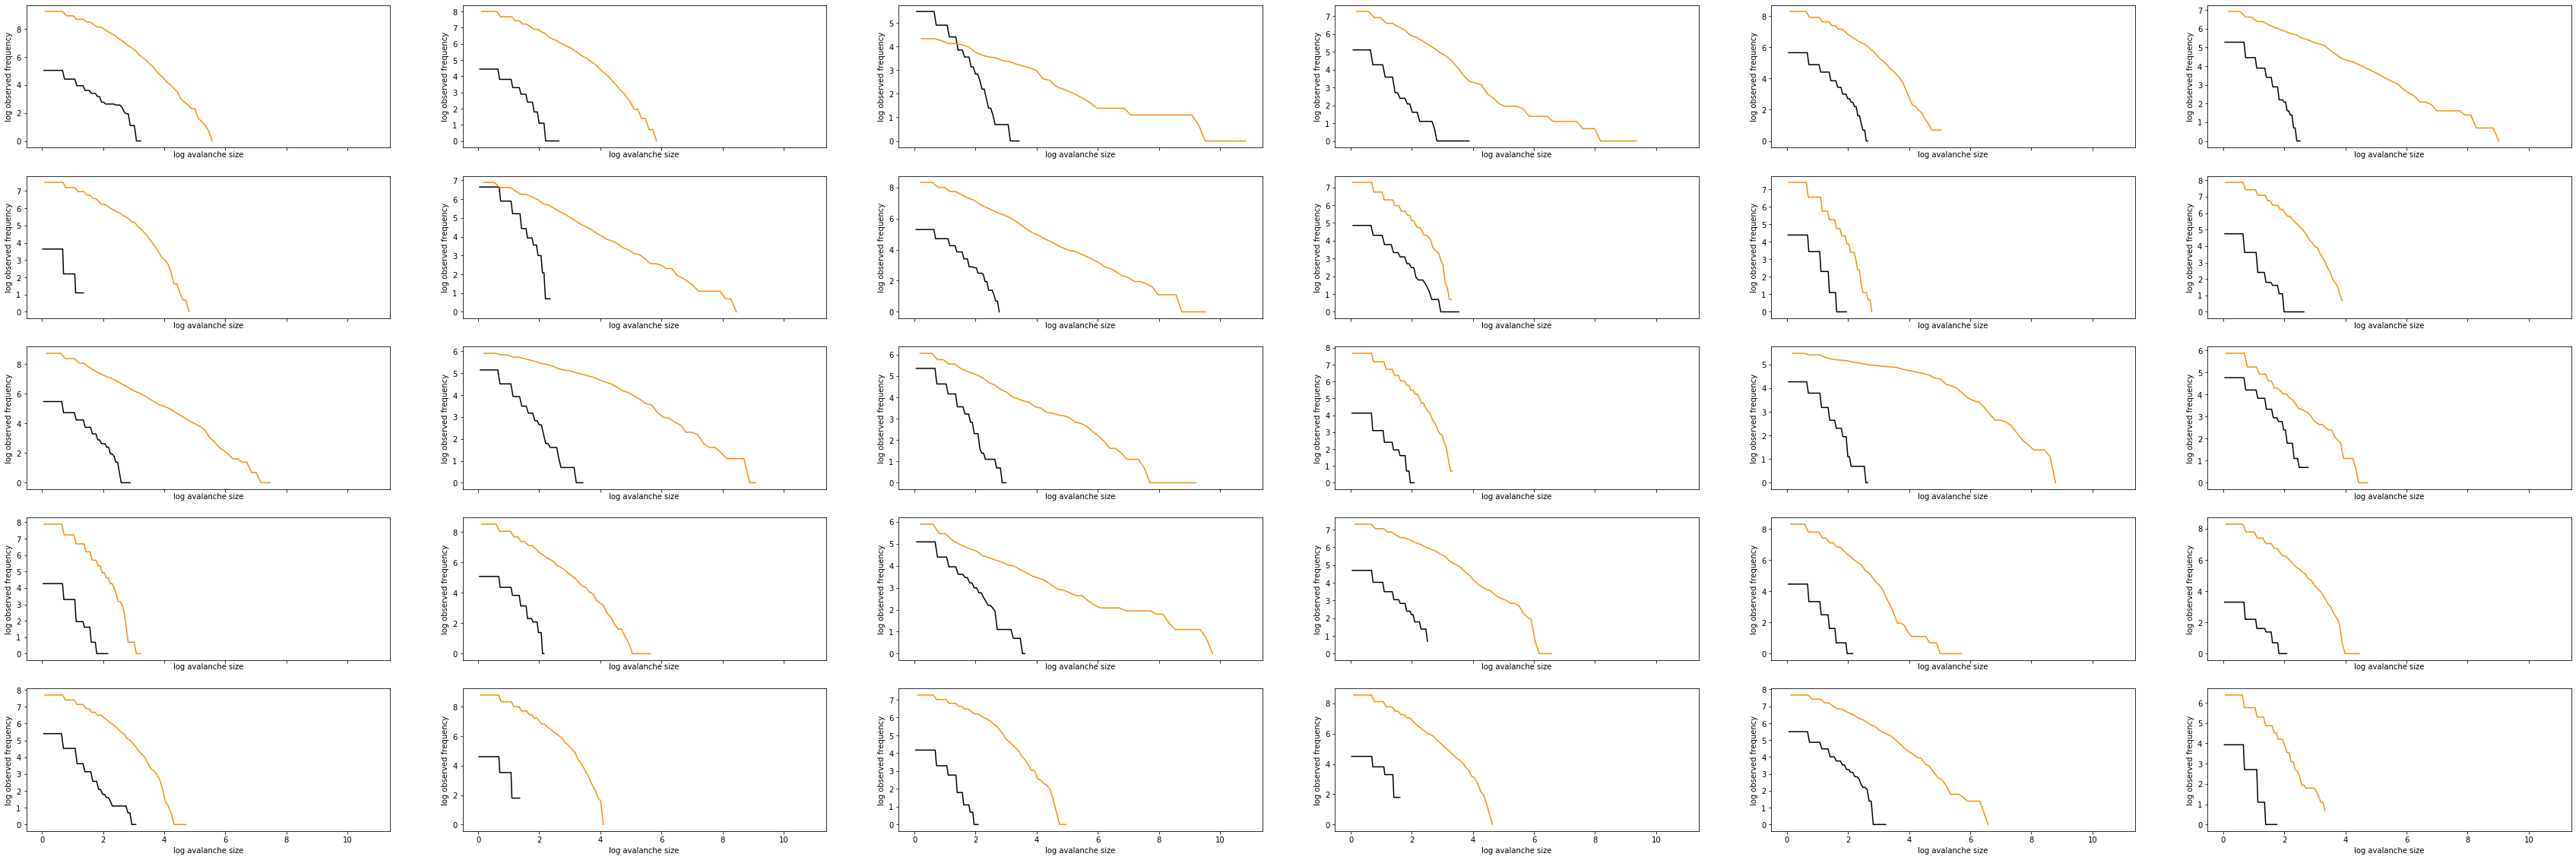

In [59]:
reload(cs)
tid  = 0 # np.argmin(abs(trange - AS['dt']))
pid  = 0 # np.argmin(abs(prange - BN['peak_height']))
f,ax = plt.subplots(5,6, figsize=(60,20), sharex = True)

Bl = []
Sz = []
for s in range(len(Sweep)):
    i  = (np.floor(s/6).astype('int'), np.mod(s,6)-1)
#     cs.plot_ccdf(Sweep[s]['Avalanches'][pid][tid][0], ax = ax[i], plottype='line', color = 'black')
#     cs.plot_ccdf(Sweep[s]['Avalanches'][pid][tid][1], ax = ax[i], plottype='line', color = 'darkorange')
#     Bl.append(Sweep[s]['Avalanches'][pid][tid][0].T)
#     Sz.append(Sweep[s]['Avalanches'][pid][tid][1].T)
    
    cs.plot_ccdf(Sweep[s]['AvTimes'][pid][tid][0], ax = ax[i], plottype='line', color = 'black')
    cs.plot_ccdf(Sweep[s]['AvTimes'][pid][tid][1], ax = ax[i], plottype='line', color = 'darkorange')
    Bl.append(Sweep[s]['AvTimes'][pid][tid][0].T)
    Sz.append(Sweep[s]['AvTimes'][pid][tid][1].T)

    
f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+Parset['band'][0]+'.svg')


### Plot Summary PDF

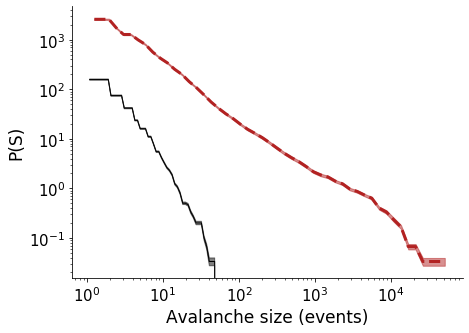

In [60]:
f, ax = plt.subplots(1,1,figsize=(7,5), sharex = True)
bl = []
sz = []
for b in Bl: bl = np.append(bl, b)
for s in Sz: sz = np.append(sz, s)
reload(cs)
cs.plot_ccdf(Bl, ax = ax, plottype='distribution', color='k')
cs.plot_ccdf(Sz, ax = ax, plottype='distribution', color='firebrick', linewidth = 3, linestyle = '--')

# Match formatting
#-----------------------------------------------------------
ax.set_xlabel('Avalanche size (events)', size =17)
ax.set_ylabel('P(S)', size = '17')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+Parset['band'][0]+'summary.svg')



### Plot parameters of power law fit 

In [27]:
Sweep = pickle.load(open(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+
                         os.sep+Parset['band'][0]+'.pkl', 'rb'))
AS['dt']             = Parset['dt']
BN['peak_height']    = Parset['peak_height']

tid  = np.argmin(abs(trange - AS['dt']))
pid  = np.argmin(abs(prange - BN['peak_height']))

In [61]:
alphas = np.zeros((len(Sweep),2))
si     = 0
for s in Sweep:
    blft = pl.Fit(s['AvTimes'][pid][tid][0], discrete=True, verbose=False)
    szft = pl.Fit(s['AvTimes'][pid][tid][1], discrete=True, verbose=False)
    alphas[si,:] = [blft.alpha, szft.alpha]
    si   = si + 1

/Users/roschkoenig/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/roschkoenig/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


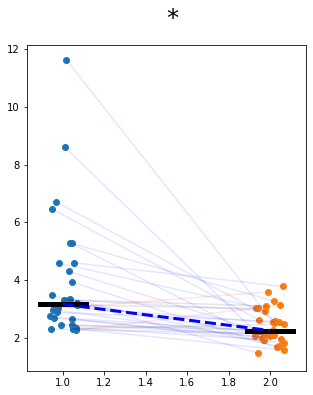

In [62]:
reload(cs)
f, ax = plt.subplots(1,1,figsize=(5,6), sharex = True)
cs.plot_groupcompare(alphas, ax = ax, connect=True, xspread=0.075)
f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+Parset['band'][0]+'_alphas.svg')


# Dimensionality evaluation

In [39]:
# Load patient data
#-----------------------------------------------------------------------------------
Subdata = []
for sub in Sublist:
    sub = cs.subject_load(sub, Parset)
    Subdata.append(sub)

### Estimation

In [43]:
# Dimensionality reduction
#-----------------------------------------------------------------------------------
Fs          = 1000                # Sampling rate <- this needs double checking 
window_size = 3 * Fs              # window size in sample number 
PS          = []                  # Parameter sweep structure
k           = 0                   # counter for subplot
fromid      = 2                   # exclude component ids below for linear fit
toid        = 10                  # exclude component ids above for linear fit

conditions  = ['Base', 'Seiz']    # Conditions to be estimated

for s in Subdata:                 # Loop through individual subjects 
    ps = {}
    for c in conditions:          # Loop through contions to be estimated 
        
        print('Subject ' +str(k+1)+ ' of ' +str(len(Subdata)))
        print('Processing '+c+' data - Sliding windows: ', end='')

        # Housekeeping 
        #---------------------------------------------------------------------------
        ALL_variances = np.ndarray(0)
        ALL_fits      = []
        linfit        = []
        minlength     = min([ds.shape[1] for ds in s[c+'_dat']])
        windows       = np.arange(0, minlength-window_size, window_size)

        # Loop through the data in chunks of the 'window_size'
        #---------------------------------------------------------------------
        for w in windows:
            variances = np.ndarray(0)
            fits      = []
            for d in range(3):
                data         = s[c+'_dat'][d][:,w:(w+window_size-1)]
                n_components = data.shape[0]
                pca          = decomposition.PCA(n_components) #Define decomposition
                fit          = pca.fit(data)
                variance     = fit.explained_variance_ratio_

                fits.append(fit)
                variances    = variance if variances.shape[0] == 0 else np.vstack((variances, variance))

            y = np.log(np.mean(variances, axis=0))[:-toid]
            x = np.log(np.arange(0,len(y),1)+toid)
            linfit.append(np.polyfit(x[fromid:], y[fromid:], 1))
            ALL_fits.append(fits)
            print('>', end='')
        
        print('')
        ps[c+'_fits']       = ALL_fits
        ps[c+'_linfit']     = linfit
        ps['Window_length'] = window_size
        ps['Fs']            = Fs
        k                   = k+1
    
    PS.append(ps)    
print('All done')
    

    

Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>>
Subject 1 of 30
Processing Seiz data - Sliding windows: >>>>>>>>>>>>>>>>>>>>>>>>>
Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>>
Subject 1 of 30
Processing Seiz data - Sliding windows: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>>
Subject 1 of 30
Processing Seiz data - Sliding windows: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>>
Subject 1 of 30
Processing Seiz data - Sliding windows: >>>>>>>>>>>>>>>>>>>>>>
Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>
Subject 1 of 30
Processing Seiz data - Sliding windows: >>>>>>>>>>>>>>>
Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>>
Subject 1 of 30
Processing Seiz data - Sliding windows: >>>>>>>>>>>>>>>>>>>>>>>>>>>
Subject 1 of 30
Processing Base data - Sliding windows: >>>>>>>>>>>
Subject 1 of 30
Processing Se

In [42]:
data.shape

(117, 2999)

### Plot eigenspectra

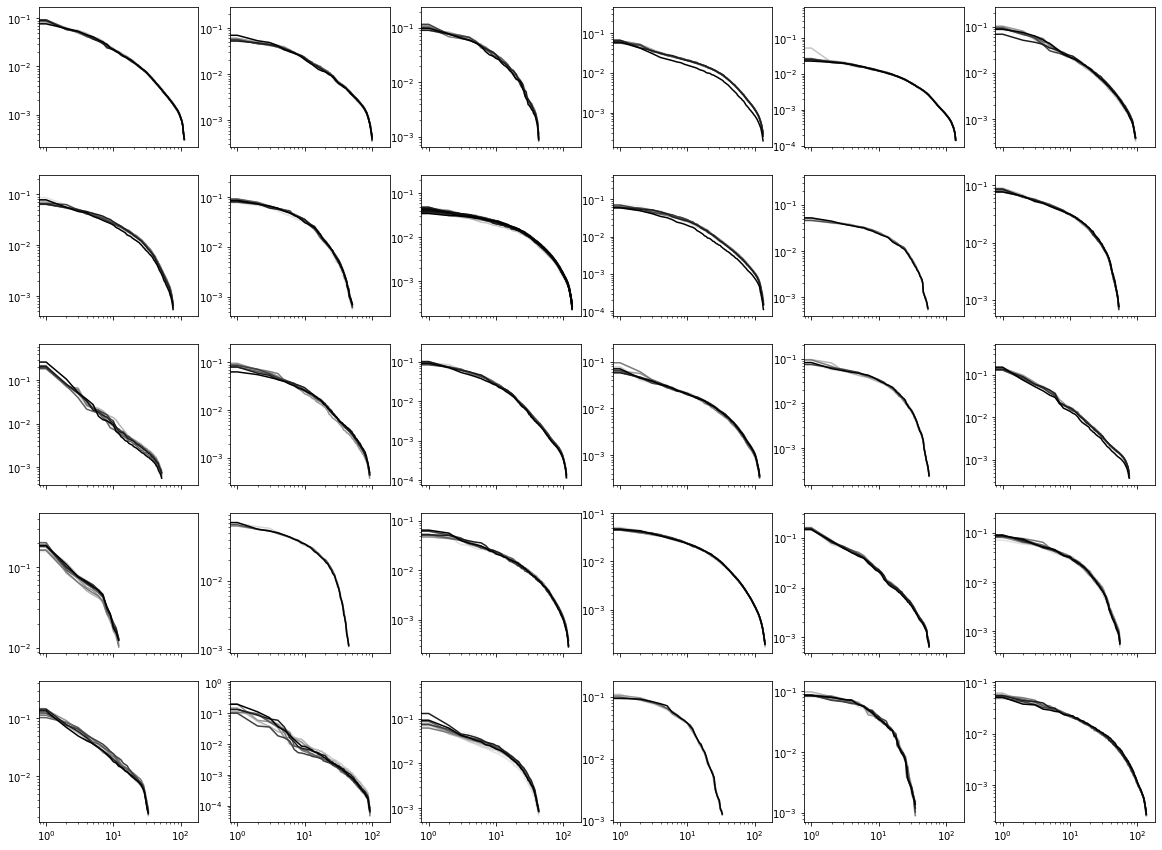

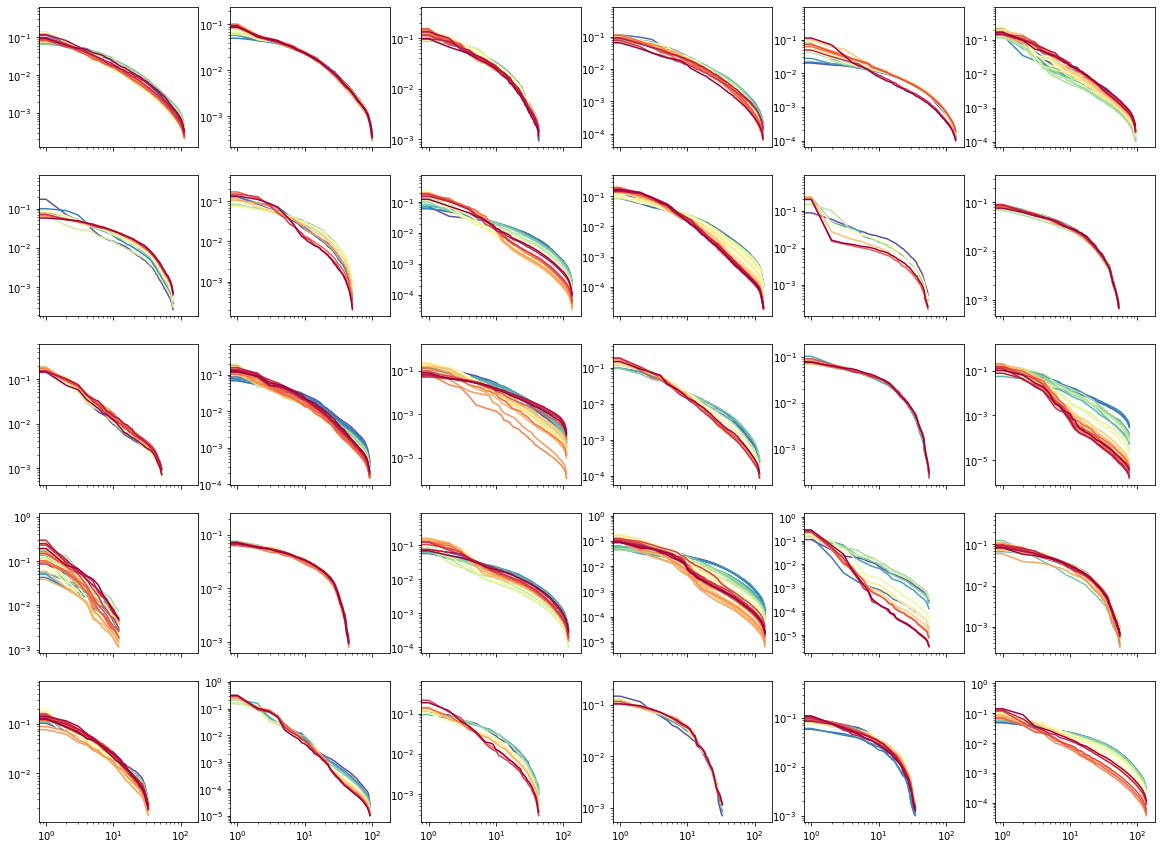

In [44]:
f1,ax1 = plt.subplots(5,6, figsize=(20,15), sharex = True)
f2,ax2 = plt.subplots(5,6, figsize=(20,15), sharex = True)
k      = 0

for s in PS:
    # Plot Baseline eigenspectra
    #---------------------------------------------------------------------------------------------
    ti = 0
    for t in s['Base_fits']:
        scalarMap = cmx.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(s['Base_fits'])-1), cmap=plt.get_cmap('Greys') )
        v = [pca.explained_variance_ratio_ for pca in t]
        ax1.flatten()[k].loglog(np.mean(v,axis=0)[:-3], color=scalarMap.to_rgba(ti))
        ti = ti + 1
        
    # Plot seizure eigenspectra
    #---------------------------------------------------------------------------------------------
    ti = 0
    for t in s['Seiz_fits']:
        scalarMap = cmx.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(s['Seiz_fits'])-1), cmap=plt.get_cmap('Spectral_r') )
        v = [pca.explained_variance_ratio_ for pca in t]
        ax2.flatten()[k].loglog(np.mean(v,axis=0)[:-3], color=scalarMap.to_rgba(ti))
        ti = ti + 1
    k = k + 1

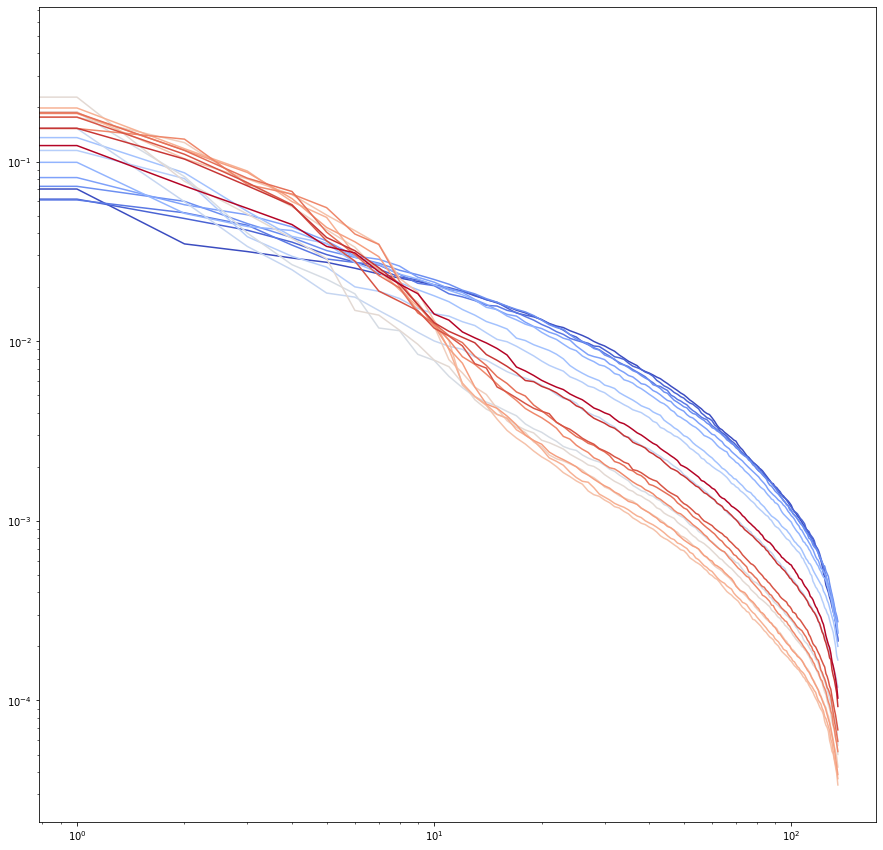

In [137]:
sid = 8
s = PS[sid]
data = Subdata[sid]['Seiz_dat']
f, a = plt.subplots(1,1, figsize = (15,15))
# Plot seizure eigenspectra
#---------------------------------------------------------------------------------------------
ti = 0
for t in s['Seiz_fits']:
    scalarMap = cmx.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(s['Seiz_fits'])-1), cmap=plt.get_cmap('coolwarm') )
    v = [pca.explained_variance_ratio_ for pca in t]
    a.loglog(np.mean(v,axis=0)[:-3], color=scalarMap.to_rgba(ti))
    ti = ti + 1

f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+Parset['band'][0]+'_eigenspectra.svg')


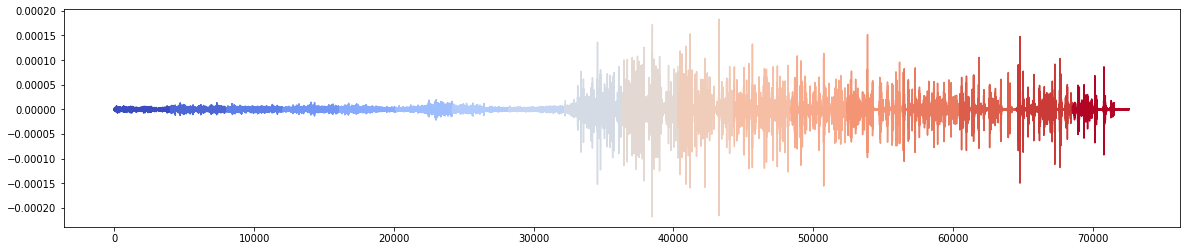

In [133]:
scalarMap = cmx.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(s['Seiz_fits'])-1), cmap=plt.get_cmap('coolwarm') )
wins = np.linspace(0,len(data[0][0])-500,len(s['Seiz_fits'])+1).astype(int)
f, a = plt.subplots(1,1, figsize = (20,4))
ci   = 0
for wi in range(len(wins)-1):
    a.plot(np.arange(wins[wi],wins[wi+1]), data[0][44][wins[wi]:wins[wi+1]], color=scalarMap.to_rgba(ci))
    ci = ci + 1

f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+Parset['band'][0]+'_example_trace.svg')    


### Plot alphas 

In [123]:
bsalphas = []
szalphas = []
for s in PS:
    bsalphas.append(np.mean(np.abs([p[0] for p in s['Base_linfit']])))
    szalphas.append(np.mean(np.abs([p[0] for p in s['Seiz_linfit']])))

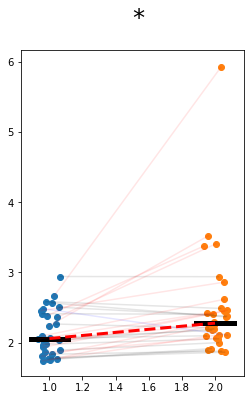

In [135]:
f, ax = plt.subplots(1,1,figsize=(4,6), sharex = True)
cs.plot_groupcompare(np.vstack((bsalphas, szalphas)).T, ax = ax, connect=True, xspread=0.075)

f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+Parset['band'][0]+'_eigenalphas.svg')


In [129]:
np.vstack((bsalphas, szalphas))

array([[1.89379279, 1.76515453, 2.41289716, 1.8069428 , 1.78719601,
        2.01296554, 1.97700698, 2.56469798, 1.74105204, 1.97184871,
        2.06351726, 2.06354469, 2.2649809 , 2.03266165, 2.45468112,
        1.75901571, 2.58399841, 2.23583611, 2.65940457, 1.83575741,
        1.76794467, 1.93325674, 2.35960657, 2.50508126, 2.05312711,
        2.38543492, 2.09372897, 2.94206691, 2.48283079, 1.86066493],
       [1.99967011, 1.91475009, 2.40336729, 2.28851479, 1.86405489,
        2.19568143, 2.05442282, 2.36693903, 2.11168101, 2.46124042,
        2.09779719, 2.17483627, 2.21055149, 2.26753306, 2.86051754,
        2.24965858, 2.48775465, 3.5215623 , 5.92000516, 1.87849453,
        1.88980206, 2.4471738 , 3.4078972 , 2.37867091, 2.42001236,
        3.37493041, 2.61588374, 2.93965908, 2.10761514, 2.06649339]])

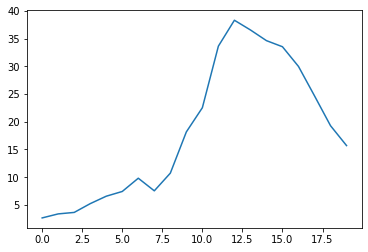

In [623]:
s = PS[8]
basealpha = np.abs([p[0] for p in s['Base_linfit']])
alphas    = (np.abs([p[0] for p in s['Seiz_linfit']]) - np.mean(basealpha)) / np.std(basealpha)
plt.plot(alphas)